In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

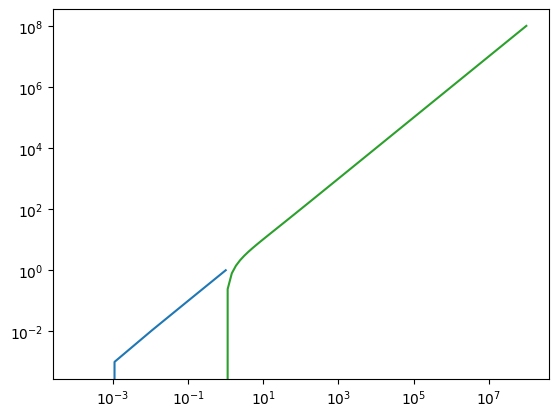

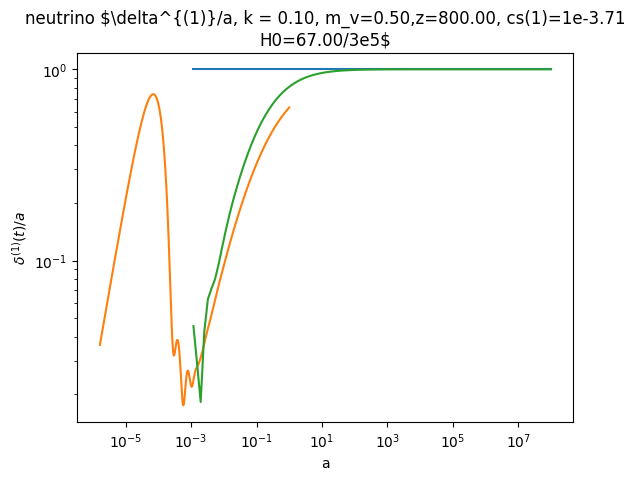

In [6]:


def TEST6(kvec=[1],k_ind=0,z=800,mv_test=1,Omega_M=0.99,
         Omega_b=0.01,PLOT_FIGUR=True,EdSitter=True,
         interpolation_type="cubic",H0_override=False,H=67):
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    H0=67
    if H0_override == True:
        H0 =H
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="linear")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    kvec = np.array(kvec)
    mv = mv_test * 1e-6
    t0_test = tid[-1]
    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 8
        return cs_factor *T_0 / a / mv
    c = cs(1)
    def test(kind,z_slut=0):
        c = cs(1)
        k = kvec[kind]
        delta_class = pts[kind]["delta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
        a_class = pts[kind]["a"]
        tau_class = pts[kind]["tau [Mpc]"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
        a0 = 1/(1+z)
        aslut = 1/(1+z_slut)
        t0 = interp_tid_from_a(aslut)
        a_span = [a0,aslut]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]    
        bonus_tid = 1_000_000_000_000
        tid_test = np.logspace(np.log10(T0),np.log10(t0 * bonus_tid),100)
        def f2(a):
            H0 = 2/(3*t0)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)
            dcdm = delta0/a0        
            val = 2 * c * k  / np.sqrt(a) / H0
            res = dcdm*a+C1*Cos(val) - C2*Sin(val) + val**2*a*dcdm* (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            #print(f"{CosIntegral(val)=}")
            return res        
        def f3(a):
            H0 = 2/(3*t0)                   
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)            
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0 / np.sqrt(a))**2 * (delta0/a0)
            dcdm = delta0/a0             
            val = 2 * cs(a) * k  * np.sqrt(a) / H0
            EXP = (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            res = dcdm + C1/a * Cos(val)-C2 * Sin(val) + val**2 * dcdm * EXP            
            return res
        a_test = (tid_test/t0)**(2/3) 
        
        def func(a,y,D):
            d = y[0]
            d1 = y[1]
            d2 = 1/a**2 * (3/2 * a * D - 3/2 * a * d1)
            return [d1,d2]
        a_span = [1e-4,1]
        y0 = [ 0,1]
        D = 1
        sol = sc.solve_ivp(func,a_span,y0 = y0,args=[D])
        fig = plt.figure(np.random.randint(1,10000))
        plt.loglog(sol.t,sol.y[0])
        plt.loglog(sol.t,-sol.y[0])
        c1 = 1
        c2 = 1
        plt.loglog(a_test, a_test * D - 2*c1 / np.sqrt(a_test)+c2)
        
        fig = plt.figure(np.random.randint(1,10000))
        fig.gca().set_title("neutrino $\delta^{(1)}/a, k = %.2f, m_v=%.2f,z=%.2f, cs(1)=1e%.2f\nH0=%.2f/3e5$" %(kvec[k_ind],mv_test,z,np.log10(cs(1)),H0*3e5))
        fig.gca().set_xlabel("a")
        fig.gca().set_ylabel("$\delta^{(1)}(t)/a$")
        tid_test = np.array(tid_test)
        f4 = np.array(f3(a_test)/(delta0/a0))
        fig.gca().loglog(a_test,delta0/a0/(delta0/a0) * a_test / a_test,label="cdm approx/a")
        fig.gca().loglog(a_class,delta_neutrino_class/a_class /(delta0/a0),label="cdm clas/a")
        fig.gca().loglog(a_test,f4,label="f3 - eq. mv = %.2feV, k = %.2f"%(mv_test,kvec[k_ind]))
        
        
        def elu(x,alpha=1,beta=1):
            res = x
            if x<0:
                res = alpha* (np.exp(beta*x)-1) #+100*x0
            return res 
        
        res =  np.array([kvec[kind],H0,delta0,a0,cs(a0),neu_tid(T0),theta_neu_tid(T0)])
        return res, a_test, f4, t0 
    res, a_test, f5,t0 = test(0)
    return res, a_test, f5,t0 

res, a_test, f5,t0 =TEST6(kvec=[0.1],mv_test=0.5) 
a = np.array(a_test,dtype=np.complex_)
f5 = np.array(f5,dtype=np.complex_)
k, H0, delta0,a0,cs_a0,delta_neuT0,theta_neuT0 = res
mv_test=0.1
# cs_a,k,H0,delta0,a0,cs_a0 


/home/erik/SPECIALE/class/code/test/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


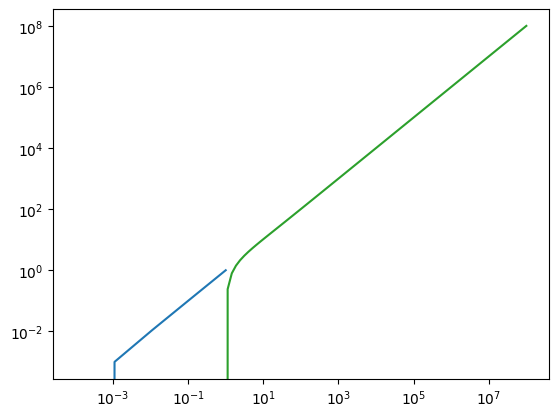

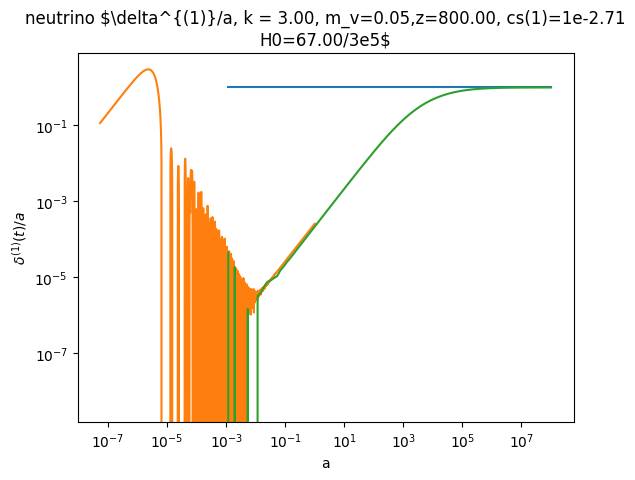

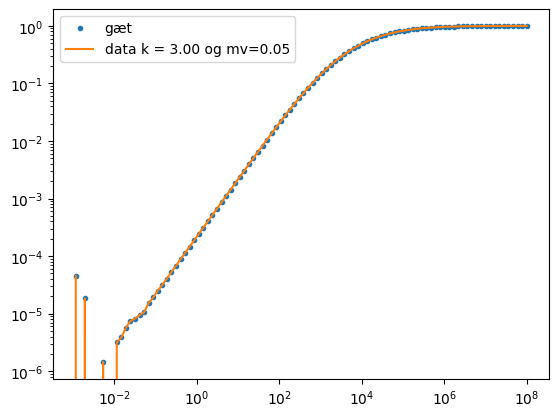

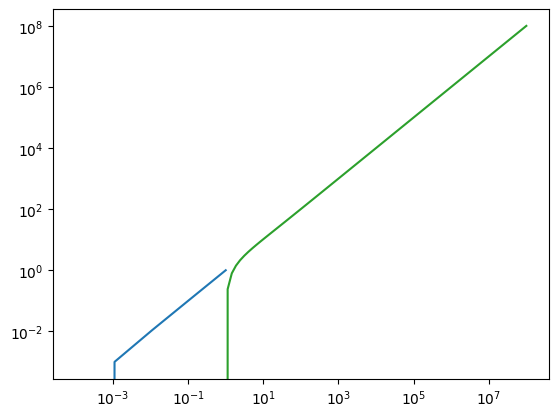

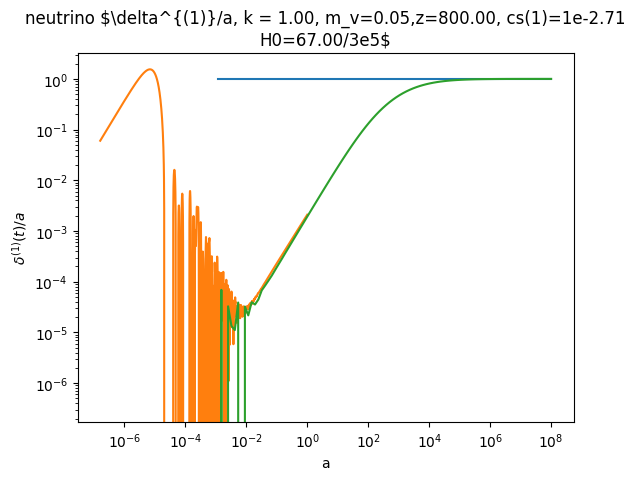

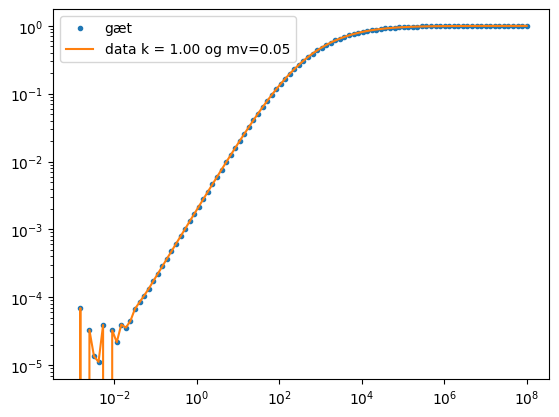

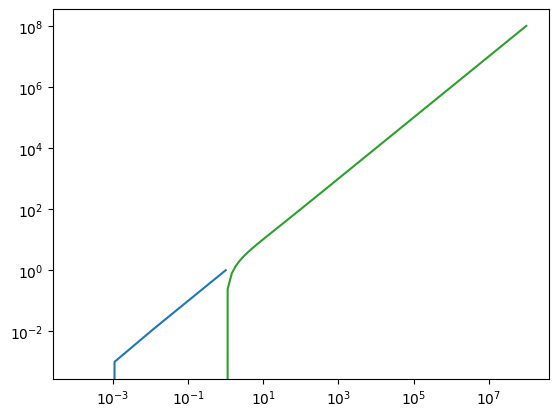

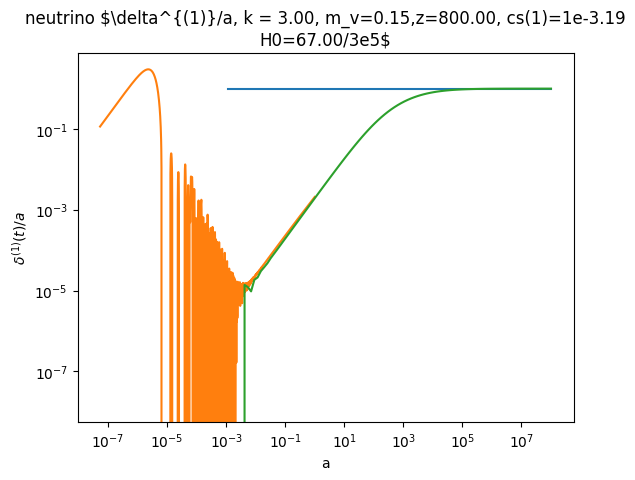

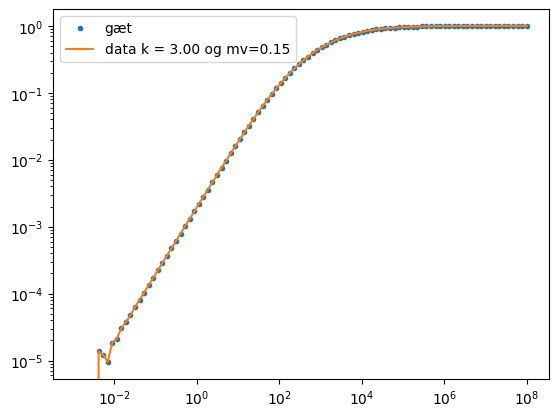

In [7]:
def T(klist=[1],mv_test=0.15): 
    res, a_test, f5,t0 =res, a_test, f5,t0 =TEST6(kvec=klist,mv_test=mv_test) 
    a = np.array(a_test,dtype=np.complex_)
    f5 = np.array(f5,dtype=np.complex_)
    k, H0, delta0,a0,cs_a0,delta_neuT0,theta_neuT0 = res 
    x0 =  k**2 /H0**2 * cs_a0 * a0
    x0 = - a / np.log(1 - f5) 
    def elu(x,alpha=1,beta=1):
        res = x
        if x<0:
            res = alpha* (np.exp(beta*x)-1) #+100*x0
        return res 
    
    F = lambda x,alpha = 1: alpha * (-np.exp(-x) +1) if x>=0 else x
    Fx = [1- np.exp(-i/x0[i_ind]) for i_ind,i in enumerate(a_test)] 
    plt.figure(np.random.randint(1,10000))
    
    plt.loglog(a,Fx,".",label="gæt")
    plt.plot(a_test,f5,label="data k = %.2f og mv=%.2f" % (k,mv_test))
     
    plt.legend()
    
T([3],0.05) 
T([1],0.05) 


T([3],0.15)  